# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run144', 'ORACLE.run138', 'ORACLE.run120', 'ORACLE.run114', 'ORACLE.run126', 'ORACLE.run18', 'ORACLE.run150', 'ORACLE.run132'}


{'Wisig_1', 'Wisig_4', 'Wisig_3', 'Wisig_2'}


tensor([[[-0.1920,  0.2208,  0.3168,  ..., -0.5952,  0.9311,  1.0463],
         [-0.9215, -0.2688,  0.4224,  ..., -1.0079, -1.3343, -0.2016]],

        [[-0.3228,  0.2184, -0.7596,  ..., -0.3798, -1.1109,  0.0760],
         [ 0.1899, -0.4747,  0.2659,  ...,  1.0539, -0.5507, -0.4937]],

        [[-0.9435, -0.7677,  0.2682,  ..., -0.9065,  0.3515,  0.0832],
         [ 0.7122, -0.4625, -1.1007,  ...,  0.1295, -1.0082,  0.7955]],

        ...,

        [[-0.6804,  0.3998,  0.2455,  ..., -0.4980,  0.6313, -0.8136],
         [-0.7786,  0.4699,  1.0661,  ...,  0.7996,  1.2275,  0.0070]],

        [[-1.1254,  0.3051, -0.1288,  ..., -1.4847,  0.6576,  1.1525],
         [ 0.8271,  0.5152,  0.1763,  ..., -1.5728, -1.0033, -0.5084]],

        [[-1.4265, -0.5774, -0.2106,  ...,  0.2989,  0.8287,  1.1412],
         [-0.6996,  0.5434,  0.0883,  ..., -0.5978,  0.0883, -0.0136]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.7420, train_label_loss: 2.7850, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3823.3300, train_label_loss: 2.8154, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3945.8050, train_label_loss: 1.5034, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 4007.1023, train_label_loss: 2.2045, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3946.1700, train_label_loss: 1.4265, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3782.6060, train_label_loss: 1.3998, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 4341.2227, train_label_loss: 1.9135, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 4244.6725, train_label_loss: 1.1880, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 4275.3183, train_label_loss: 1.5621, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 4287.3934, train_label_loss: 1.1992, 


epoch: 1, source_val_acc_label: 0.5334, target_val_acc_label: 0.6059, source_val_label_loss: 1.2253, target_val_label_loss: 6.5763, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 4.5510, train_label_loss: 1.7335, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3861.5722, train_label_loss: 1.3584, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3934.3628, train_label_loss: 1.1424, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3972.6387, train_label_loss: 1.0826, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3953.4062, train_label_loss: 1.3498, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3950.4239, train_label_loss: 0.8281, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3947.3353, train_label_loss: 0.7160, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3968.0905, train_label_loss: 1.0021, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 4022.7591, train_label_loss: 0.7678, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 4240.4502, train_label_loss: 0.9183, 


epoch: 2, source_val_acc_label: 0.5932, target_val_acc_label: 0.6593, source_val_label_loss: 1.0646, target_val_label_loss: 7.3282, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 4.2247, train_label_loss: 0.6942, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 4351.6539, train_label_loss: 0.6222, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 4130.6667, train_label_loss: 1.6279, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 4015.1267, train_label_loss: 1.0621, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3952.8547, train_label_loss: 0.9570, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3991.5300, train_label_loss: 0.7509, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 4004.7666, train_label_loss: 0.4305, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 4009.6225, train_label_loss: 0.7397, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 4026.7693, train_label_loss: 0.7965, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3988.8202, train_label_loss: 0.5758, 


epoch: 3, source_val_acc_label: 0.6044, target_val_acc_label: 0.6788, source_val_label_loss: 1.0464, target_val_label_loss: 7.8359, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 4.0715, train_label_loss: 0.8916, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 4227.4091, train_label_loss: 1.1153, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 4464.7326, train_label_loss: 0.6995, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 4395.2043, train_label_loss: 0.5196, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 5094.2272, train_label_loss: 1.0899, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 4043.7649, train_label_loss: 1.1073, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 4059.5908, train_label_loss: 0.5472, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3786.2827, train_label_loss: 0.4380, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3805.8419, train_label_loss: 0.6859, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3779.4399, train_label_loss: 0.9088, 


epoch: 4, source_val_acc_label: 0.6106, target_val_acc_label: 0.6851, source_val_label_loss: 1.0657, target_val_label_loss: 9.3032, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.8813, train_label_loss: 0.6955, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3832.1435, train_label_loss: 0.7284, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 4251.6245, train_label_loss: 0.5338, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 4200.8322, train_label_loss: 0.3655, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 4248.1001, train_label_loss: 0.9946, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 4337.0471, train_label_loss: 0.8563, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 4362.3228, train_label_loss: 0.7130, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 4590.3197, train_label_loss: 1.0263, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3817.9831, train_label_loss: 0.7201, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3861.1153, train_label_loss: 0.6293, 


epoch: 5, source_val_acc_label: 0.6094, target_val_acc_label: 0.6817, source_val_label_loss: 1.1004, target_val_label_loss: 10.1804, 


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.8473, train_label_loss: 0.4235, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3832.9524, train_label_loss: 0.5911, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3900.6656, train_label_loss: 0.9262, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3860.2306, train_label_loss: 0.8311, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3995.0838, train_label_loss: 0.4297, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 4312.7029, train_label_loss: 0.5426, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 4431.9487, train_label_loss: 0.2545, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 4496.4371, train_label_loss: 0.1234, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 4333.9807, train_label_loss: 0.8293, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 4323.0392, train_label_loss: 0.1769, 


epoch: 6, source_val_acc_label: 0.6157, target_val_acc_label: 0.6942, source_val_label_loss: 1.1502, target_val_label_loss: 11.2494, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 4.1225, train_label_loss: 0.7645, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3865.4017, train_label_loss: 0.8652, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3924.2466, train_label_loss: 0.6359, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3916.7751, train_label_loss: 0.4009, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3915.8629, train_label_loss: 0.3960, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3973.4500, train_label_loss: 0.3062, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3933.3917, train_label_loss: 0.5613, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 4104.1739, train_label_loss: 0.5232, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 4496.5047, train_label_loss: 0.5990, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 4379.8665, train_label_loss: 0.2851, 


epoch: 7, source_val_acc_label: 0.6131, target_val_acc_label: 0.6962, source_val_label_loss: 1.2376, target_val_label_loss: 12.8195, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 4.3185, train_label_loss: 0.5938, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 4224.6059, train_label_loss: 0.5096, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 4165.3559, train_label_loss: 0.3019, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 4242.5328, train_label_loss: 0.3287, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 4155.0347, train_label_loss: 0.2576, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 4462.3525, train_label_loss: 0.4693, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 4340.8935, train_label_loss: 0.9341, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 4168.7049, train_label_loss: 0.1783, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 4232.9480, train_label_loss: 0.3166, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 4168.6073, train_label_loss: 0.5948, 


epoch: 8, source_val_acc_label: 0.6065, target_val_acc_label: 0.6954, source_val_label_loss: 1.3225, target_val_label_loss: 13.9642, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 4.3738, train_label_loss: 0.4076, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 4162.4011, train_label_loss: 0.7122, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 4332.3421, train_label_loss: 0.2569, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 4178.3923, train_label_loss: 0.2171, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 4120.1023, train_label_loss: 0.2411, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 4189.2294, train_label_loss: 0.7256, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 4349.0302, train_label_loss: 0.0782, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 4750.5374, train_label_loss: 0.3755, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 5037.0982, train_label_loss: 0.0943, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 5091.3971, train_label_loss: 0.1718, 


epoch: 9, source_val_acc_label: 0.6029, target_val_acc_label: 0.6912, source_val_label_loss: 1.3966, target_val_label_loss: 15.0453, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 5.1349, train_label_loss: 0.1581, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 4689.6088, train_label_loss: 0.1556, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 4850.6100, train_label_loss: 0.1828, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 4939.7893, train_label_loss: 0.3108, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 4849.5965, train_label_loss: 0.2708, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 4988.3358, train_label_loss: 0.1360, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 4905.8288, train_label_loss: 0.0925, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 5061.2601, train_label_loss: 0.5219, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 5029.1844, train_label_loss: 0.6688, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 4982.1334, train_label_loss: 0.0965, 


epoch: 10, source_val_acc_label: 0.6042, target_val_acc_label: 0.6979, source_val_label_loss: 1.4720, target_val_label_loss: 15.8984, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 5.2499, train_label_loss: 0.0629, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 4943.8622, train_label_loss: 0.1241, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 5395.1754, train_label_loss: 0.4002, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 5138.5157, train_label_loss: 0.7045, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 5095.3618, train_label_loss: 0.2737, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 4897.2470, train_label_loss: 0.5791, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 4884.6307, train_label_loss: 0.5302, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 4853.6728, train_label_loss: 0.4509, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 4907.7505, train_label_loss: 0.0670, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 4865.9986, train_label_loss: 0.3502, 


epoch: 11, source_val_acc_label: 0.6090, target_val_acc_label: 0.7032, source_val_label_loss: 1.5698, target_val_label_loss: 17.1596, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 5.1057, train_label_loss: 0.6190, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3819.4420, train_label_loss: 0.0418, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3897.1237, train_label_loss: 0.1466, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3854.7673, train_label_loss: 0.4583, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3857.3894, train_label_loss: 0.2292, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3829.6477, train_label_loss: 0.4521, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3883.7375, train_label_loss: 0.5283, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3943.6292, train_label_loss: 0.0652, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3989.1771, train_label_loss: 0.2170, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 4023.3135, train_label_loss: 0.2196, 


epoch: 12, source_val_acc_label: 0.6047, target_val_acc_label: 0.6984, source_val_label_loss: 1.6571, target_val_label_loss: 18.3768, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 4.2856, train_label_loss: 0.4386, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 4081.1884, train_label_loss: 0.2484, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 5075.5674, train_label_loss: 0.2251, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 4000.0912, train_label_loss: 0.6161, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3935.8705, train_label_loss: 0.0657, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3921.1961, train_label_loss: 0.0943, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3918.3103, train_label_loss: 0.3630, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3933.8947, train_label_loss: 0.1022, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 4026.7490, train_label_loss: 0.2355, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 4014.0321, train_label_loss: 0.0558, 


epoch: 13, source_val_acc_label: 0.5959, target_val_acc_label: 0.6973, source_val_label_loss: 1.7402, target_val_label_loss: 19.4203, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 4.0191, train_label_loss: 0.1772, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 4077.4287, train_label_loss: 0.2513, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 4236.3506, train_label_loss: 0.7662, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 4161.4892, train_label_loss: 0.2410, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 4492.1573, train_label_loss: 0.1587, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 4403.5509, train_label_loss: 0.2308, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3931.3859, train_label_loss: 0.1354, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3855.0505, train_label_loss: 0.0275, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 4002.6021, train_label_loss: 0.0723, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 4037.3887, train_label_loss: 0.1742, 


epoch: 14, source_val_acc_label: 0.5991, target_val_acc_label: 0.7002, source_val_label_loss: 1.7981, target_val_label_loss: 20.0150, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.9429, train_label_loss: 0.0086, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3803.4392, train_label_loss: 0.7428, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 4084.3473, train_label_loss: 0.0085, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 4465.0416, train_label_loss: 0.3751, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 4194.4917, train_label_loss: 0.3853, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 4170.5958, train_label_loss: 0.1592, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 4236.2590, train_label_loss: 0.5350, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 4634.8293, train_label_loss: 0.1745, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 3946.5899, train_label_loss: 0.1332, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 3849.9933, train_label_loss: 0.0414, 


epoch: 15, source_val_acc_label: 0.6043, target_val_acc_label: 0.7001, source_val_label_loss: 1.8734, target_val_label_loss: 21.5530, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

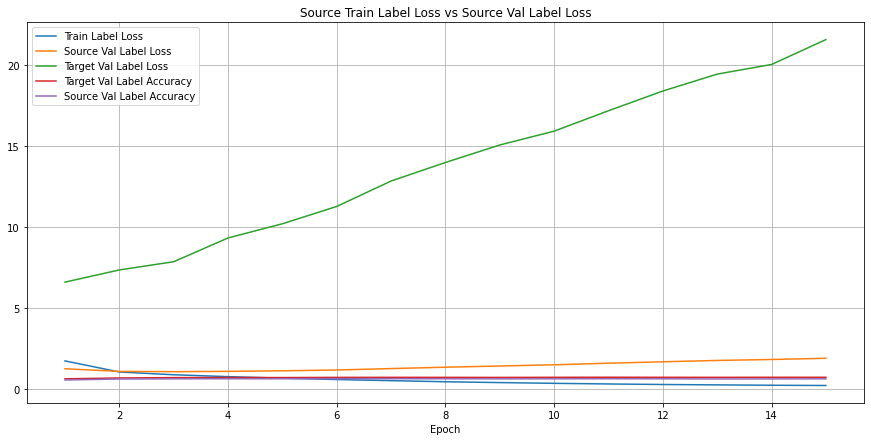

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

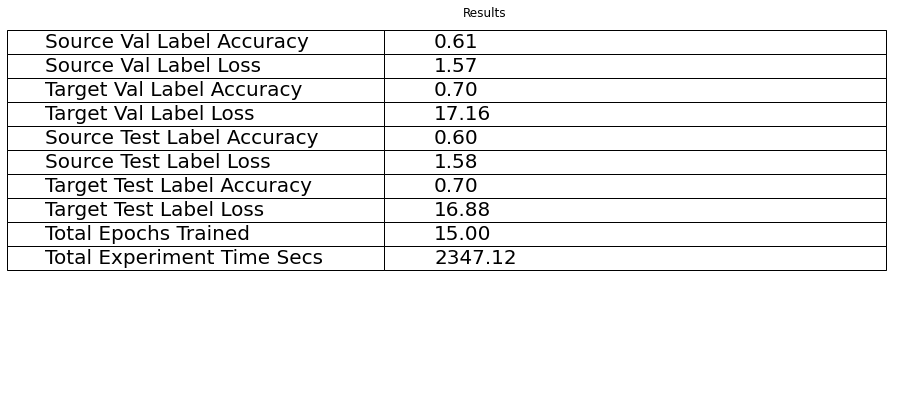

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

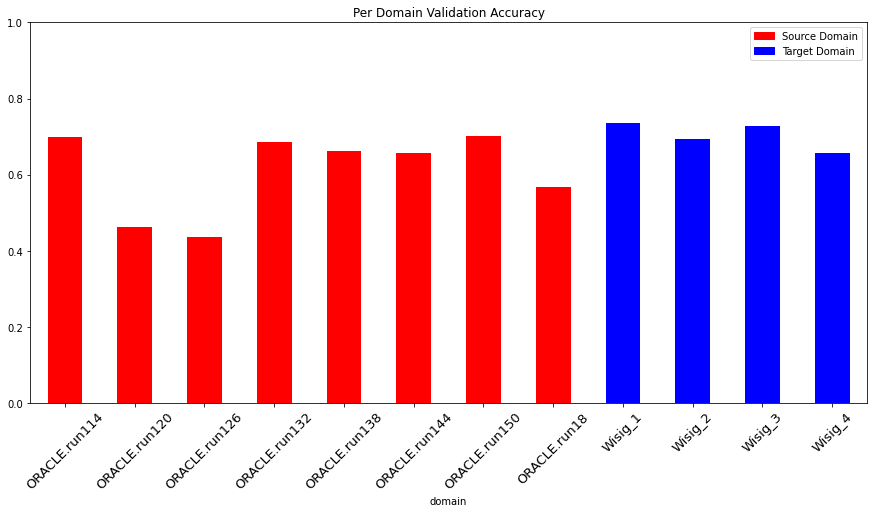

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.6020182291666667 Target Test Label Accuracy: 0.7039337474120083
Source Val Label Accuracy: 0.6089518229166667 Target Val Label Accuracy: 0.7031580338266384


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}